# Basic Setup

Import code from either Google Colab or local drive.
Select that option by either executing the first or second cell.

In [1]:
# SET HERE if notebook gets executed on google colab or locally
is_on_colab = False

In [2]:
if is_on_colab:
    # Google Colab setup
    from google.colab import drive
    drive.mount('/content/drive')

    import os
    os.chdir("drive/My Drive/adl4cv")

In [3]:
# ONLY NECESSARY FOR LOCAL EXECUTION (WORKS WITHOUT THIS CELL IN GOOGLE COLAB)
# Setup that is necessary for jupyter notebook to find sibling-directories
# see: https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im

if not is_on_colab:
    import os
    import sys
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

In [4]:
# Imports for this notebook

from networks.temporal_encoder_network import TemporalEncoder
from training.solver import Solver
from training.sequence_dataloader import FaceForensicsVideosDataset, ToTensor
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler
import torch

In [5]:
# Check training on GPU?

cuda = torch.cuda.is_available()

print("Training is on GPU with CUDA: {}".format(cuda))

device = "cuda:0" if cuda else "cpu"

print("Device: {}".format(device))


Training is on GPU with CUDA: True
Device: cuda:0


# Load Data and Model

*   Load FaceForensics sequences: Choose a list of corresponding file-paths.
*   Load the model for this notebook.
*   Enable or disable usage of optical flow / warp as input.

In [6]:
# Decide here if using the 100 videos dataset or the 1000 videos dataset

is_large_dataset = True # because we constructed two different folders, one with 100 videos, one with 1000 videos, we need to choose here for file-paths to be resolved correctly later.

print("Will use 100 videos dataset: {}. Will use 1000 videos dataset: {}".format(not is_large_dataset, is_large_dataset))

# Decide here if using optical flow is desired
# If yes: warps will be calculated in dataloader and model/solver will get it as an input
# If no: warps will not be calculated and model/solver do not get it as an input

opticalFlowEnabled = False

print("Will use Optical Flow / Warp as input for network: {}".format(opticalFlowEnabled))


Will use 100 videos dataset: False. Will use 1000 videos dataset: True
Will use Optical Flow / Warp as input for network: False


In [7]:
# Load Dataset from drive location

root_path = "/content/drive/My Drive/" if is_on_colab else "F:/Google Drive/"
root_dir = root_path # saved for stuff that does not need the faceforensics suffix in it, e.g. in model saving

dataset_root = "FaceForensics_large" if is_large_dataset else "FaceForensics_Sequences"
root_path += dataset_root

sequence = "sequences_299x299_10seq@10frames_skip_5_uniform" if is_large_dataset else "sequences_299x299_5seq@10frames_skip_5_uniform"
#sequence = "sequences_299x299_10seq@5frames_skip_1_uniform"

original_location = "/original_sequences/youtube/c40/" + sequence
deepfake_location = "/manipulated_sequences/Deepfakes/c40/" + sequence
face2face_location = "/manipulated_sequences/Face2Face/c40/" + sequence
faceswap_location = "/manipulated_sequences/FaceSwap/c40/" + sequence
neuraltextures_location = "/manipulated_sequences/NeuralTextures/c40/" + sequence

locations = [original_location, deepfake_location, face2face_location, faceswap_location, neuraltextures_location] #deepfake_location, face2face_location, faceswap_location

train_loc = [root_path + s + ("/train" if is_large_dataset else "") for s in locations]
val_loc = [root_path + s + ("/val" if is_large_dataset else "") for s in locations] 

train_dict = {"train-dataset-" + str(i): train_loc[i] for i in range(len(train_loc))}
val_dict = {"val-dataset-" + str(i): val_loc[i] for i in range(len(val_loc))}

# when using two fake variants: multiply fake-loss by 0.5 to account for twice as many fake than original samples
fake_weight_factor = 1.0 / (len(train_loc) - 1)

data_dict = {"fake_weight_factor": fake_weight_factor, **train_dict, **val_dict}


train_dataset = FaceForensicsVideosDataset(train_loc,
                                     transform=ToTensor(),
                                     num_frames=10, #num_frames=10
                                     max_number_videos_per_directory=3,
                                     calculateOpticalFlow=opticalFlowEnabled,
                                     verbose=False,
                                     caching=True)

val_dataset = FaceForensicsVideosDataset(val_loc,
                                     transform=ToTensor(),
                                     num_frames=10, #num_frames=10
                                     max_number_videos_per_directory=3,
                                     calculateOpticalFlow=opticalFlowEnabled,
                                     verbose=False,
                                     caching=True)

print("Loaded following data: {}".format(data_dict))


Loading directory 1/5: F:/Google Drive/FaceForensics_large/original_sequences/youtube/c40/sequences_299x299_10seq@10frames_skip_5_uniform/train


Reached maximum number of videos per directory (3), will skip the rest.
Loading directory 2/5: F:/Google Drive/FaceForensics_large/manipulated_sequences/Deepfakes/c40/sequences_299x299_10seq@10frames_skip_5_uniform/train


Reached maximum number of videos per directory (3), will skip the rest.
Loading directory 3/5: F:/Google Drive/FaceForensics_large/manipulated_sequences/Face2Face/c40/sequences_299x299_10seq@10frames_skip_5_uniform/train



Reached maximum number of videos per directory (3), will skip the rest.
Loading directory 4/5: F:/Google Drive/FaceForensics_large/manipulated_sequences/FaceSwap/c40/sequences_299x299_10seq@10frames_skip_5_uniform/train


Reached maximum number of videos per directory (3), will skip the rest.
Loading directory 5/5: F:/Google Drive/FaceForensics_large/manipulated_sequences/NeuralTextures/c40/sequences_299x299_10seq@10frames_skip_5_uniform/train


Reached maximum number of videos per directory (3), will skip the rest.
Loading directory 1/5: F:/Google Drive/FaceForensics_large/original_sequences/youtube/c40/sequences_299x299_10seq@10frames_skip_5_uniform/val





Reached maximum number of videos per directory (3), will skip the rest.
Loading directory 2/5: F:/Google Drive/FaceForensics_large/manipulated_sequences/Deepfakes/c40/sequences_299x299_10seq@10frames_skip_5_uniform/val


Reached maximum number of videos per directory (3), will skip the rest.
Loading directory 3/5: F:/Google Drive/FaceForensics_large/manipulated_sequences/Face2Face/c40/sequences_299x299_10seq@10frames_skip_5_uniform/val


Reached maximum number of videos per directory (3), will skip the rest.
Loading directory 4/5: F:/Google Drive/FaceForensics_large/manipulated_sequences/FaceSwap/c40/sequences_299x299_10seq@10frames_skip_5_uniform/val




Reached maximum number of videos per directory (3), will skip the rest.
Loading directory 5/5: F:/Google Drive/FaceForensics_large/manipulated_sequences/NeuralTextures/c40/sequences_299x299_10seq@10frames_skip_5_uniform/val


Reached maximum number of videos per directory (3), will skip the rest.
Loaded following data: {'fake_weight_factor': 0.25, 'train-dataset-0': 'F:/Google Drive/FaceForensics_large/original_sequences/youtube/c40/sequences_299x299_10seq@10frames_skip_5_uniform/train', 'train-dataset-1': 'F:/Google Drive/FaceForensics_large/manipulated_sequences/Deepfakes/c40/sequences_299x299_10seq@10frames_skip_5_uniform/train', 'train-dataset-2': 'F:/Google Drive/FaceForensics_large/manipulated_sequences/Face2Face/c40/sequences_299x299_10seq@10frames_skip_5_uniform/train', 'train-dataset-3': 'F:/Google Drive/FaceForensics_large/manipulated_sequences/FaceSwap/c40/sequences_299x299_10seq@10frames_skip_5_uniform/train', 'train-dataset-4': 'F:/Google Drive/FaceForensics_large/manipulated_sequences/NeuralTextures/c40/sequences_299x299_10seq@10frames_skip_5_uniform/train', 'val-dataset-0': 'F:/Google Drive/FaceForensics_large/original_sequences/youtube/c40/sequences_299x299_10seq@10frames_skip_5_uniform/val'

In [8]:
# Setup pytorch dataloaders
# from: https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

dataset_args = {
    "batch_size": 4,
    "validation_percentage": 0.2,
    "sequence": sequence,
    **data_dict
}

# Should set num_workers=0, otherwise the caching in the dataset does not work... but why?
num_workers = 2

if is_large_dataset:
    # here we have separate folders in the dataset: /train and /val --> use all of it for both datasets

    # Should set num_workers=0, otherwise the caching in the dataset does not work... but why?
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=dataset_args["batch_size"], 
                                            num_workers=num_workers,
                                            shuffle=True)

    validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=dataset_args["batch_size"],
                                                  num_workers=num_workers,
                                                shuffle=True)
else:
    # here we have one folder for train+val and must split it accordingly ourselfes at runtime
    # Creating data indices for training and validation splits:
    train_indices, val_indices = train_dataset.get_train_val_lists(1 - dataset_args["validation_percentage"], dataset_args["validation_percentage"])

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    # Should set num_workers=0, otherwise the caching in the dataset does not work... but why?
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=dataset_args["batch_size"], 
                                            num_workers=num_workers,
                                            sampler=train_sampler)

    validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=dataset_args["batch_size"],
                                                  num_workers=num_workers,
                                                  sampler=val_sampler)


dataset_args["train_len"] = len(train_loader)
dataset_args["val_len"] = len(validation_loader)

print("Dataset parameters: {}".format(dataset_args))

Dataset parameters: {'batch_size': 4, 'validation_percentage': 0.2, 'sequence': 'sequences_299x299_10seq@10frames_skip_5_uniform', 'fake_weight_factor': 0.25, 'train-dataset-0': 'F:/Google Drive/FaceForensics_large/original_sequences/youtube/c40/sequences_299x299_10seq@10frames_skip_5_uniform/train', 'train-dataset-1': 'F:/Google Drive/FaceForensics_large/manipulated_sequences/Deepfakes/c40/sequences_299x299_10seq@10frames_skip_5_uniform/train', 'train-dataset-2': 'F:/Google Drive/FaceForensics_large/manipulated_sequences/Face2Face/c40/sequences_299x299_10seq@10frames_skip_5_uniform/train', 'train-dataset-3': 'F:/Google Drive/FaceForensics_large/manipulated_sequences/FaceSwap/c40/sequences_299x299_10seq@10frames_skip_5_uniform/train', 'train-dataset-4': 'F:/Google Drive/FaceForensics_large/manipulated_sequences/NeuralTextures/c40/sequences_299x299_10seq@10frames_skip_5_uniform/train', 'val-dataset-0': 'F:/Google Drive/FaceForensics_large/original_sequences/youtube/c40/sequences_299x299

In [9]:
# Load Temporal Encoder II Model

model_args={
    "model_choice": "xception",
    "num_out_classes": 2,
    "dropout": 0.5,
    "num_input_images": 10, #10
    "feature_dimension": 64,
    "temporal_encoder_depth": 5,
    "delta_t": 2,
    "useOpticalFlow": opticalFlowEnabled
}

model = TemporalEncoder(num_input_images=model_args["num_input_images"],
                        model_choice=model_args["model_choice"],
                        feature_dimension=model_args["feature_dimension"],
                        temporal_encoder_depth=model_args["temporal_encoder_depth"],
                        dropout=model_args["dropout"],
                        num_out_classes=model_args["num_out_classes"],
                        delta_t=model_args["delta_t"],
                        useOpticalFlow=model_args["useOpticalFlow"])

model_args["model"] = type(model).__name__

print("Model configuration: {}".format(model_args))

print("Only the following layers of feature extractor component (pretrained!) require gradient backpropagation (param.requires_grad)")
for name, param in model.feature_extractor.named_parameters():
    if param.requires_grad:
        print("param: {} requires_grad: {}".format(name, param.requires_grad))





Model configuration: {'model_choice': 'xception', 'num_out_classes': 2, 'dropout': 0.5, 'num_input_images': 10, 'feature_dimension': 64, 'temporal_encoder_depth': 5, 'delta_t': 2, 'useOpticalFlow': False, 'model': 'TemporalEncoder'}
Only the following layers of feature extractor component (pretrained!) require gradient backpropagation (param.requires_grad)
param: 23.weight requires_grad: True
param: 23.bias requires_grad: True


# Training Visualization

Start Tensorboard for visualization of the upcoming training / validation / test steps.

In [10]:
# Start tensorboard
%load_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 4208), started 3 days, 14:10:23 ago. (Use '!kill 4208' to kill it.)

# Training

Start training process.

In [11]:
# Create unique ID for this training process for saving to disk.

from datetime import datetime
import uuid
now = datetime.now() # current date and time
id = str(uuid.uuid1())
id_suffix = now.strftime("%Y-%b-%d_%H-%M-%S") + "_" + id

log_dir = "runs/TemporalEncoderII/" + id_suffix

if not is_on_colab:
    log_dir = "../" + log_dir

print("log_dir:", log_dir)

log_dir: ../runs/TemporalEncoderII/2020-Jan-25_21-39-40_cf8422a4-3fb2-11ea-b59a-d0509936bc3f


In [12]:
# Configure solver
extra_args = {
    **model_args,
    **dataset_args
}

weights = [dataset_args["fake_weight_factor"], 1.0]
class_weights = torch.FloatTensor(weights).to(device)

print("Using following weighting scheme in cross-entropy-loss: {}\n".format(class_weights))

solver = Solver(optim=torch.optim.Adam,
                optim_args={ "lr": 1e-3,
                             "betas": (0.9, 0.999),
                             "eps": 1e-8,
                             "weight_decay": 0.001}, # is the l2 regularization parameter, see: https://pytorch.org/docs/stable/optim.html
                loss_func=torch.nn.CrossEntropyLoss(weight=class_weights),
                extra_args=extra_args,
                log_dir=log_dir)

Using following weighting scheme in cross-entropy-loss: tensor([0.2500, 1.0000], device='cuda:0')

Hyperparameters of this solver: {'loss function': 'CrossEntropyLoss', 'optimizer': 'Adam', 'learning rate': 0.001, 'weight_decay': 0.001, 'model_choice': 'xception', 'num_out_classes': 2, 'dropout': 0.5, 'num_input_images': 10, 'feature_dimension': 64, 'temporal_encoder_depth': 5, 'delta_t': 2, 'useOpticalFlow': False, 'model': 'TemporalEncoder', 'batch_size': 4, 'validation_percentage': 0.2, 'sequence': 'sequences_299x299_10seq@10frames_skip_5_uniform', 'fake_weight_factor': 0.25, 'train-dataset-0': 'F:/Google Drive/FaceForensics_large/original_sequences/youtube/c40/sequences_299x299_10seq@10frames_skip_5_uniform/train', 'train-dataset-1': 'F:/Google Drive/FaceForensics_large/manipulated_sequences/Deepfakes/c40/sequences_299x299_10seq@10frames_skip_5_uniform/train', 'train-dataset-2': 'F:/Google Drive/FaceForensics_large/manipulated_sequences/Face2Face/c40/sequences_299x299_10seq@10frame

START TRAIN on device: cuda:0


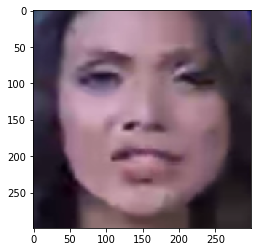

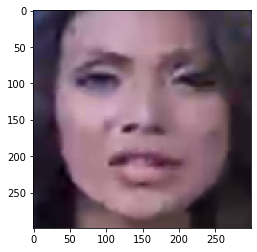

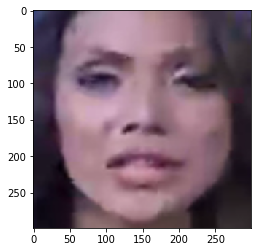

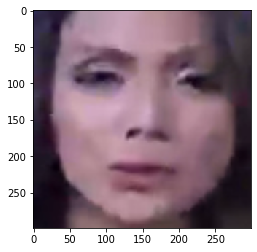

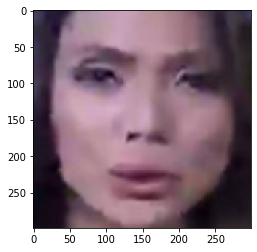

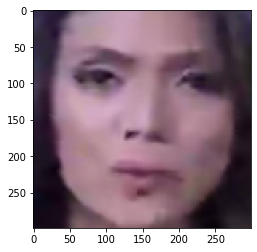

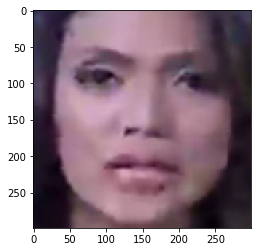

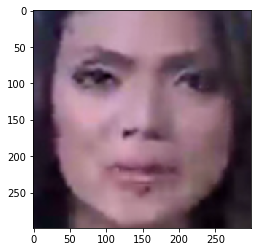

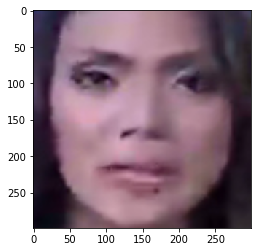

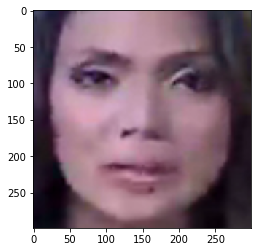

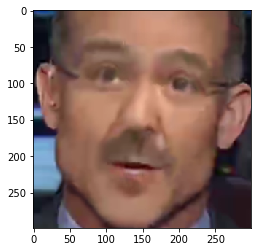

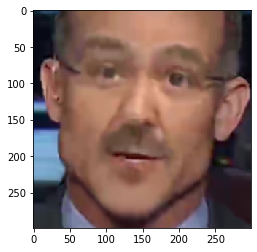

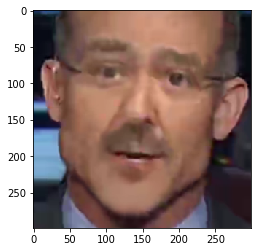

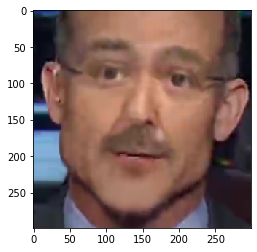

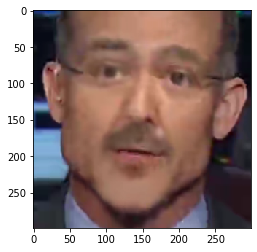

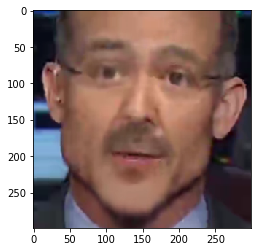

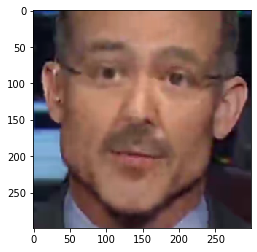

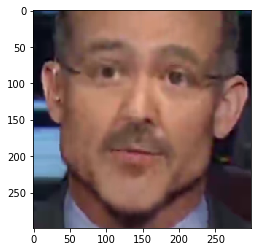

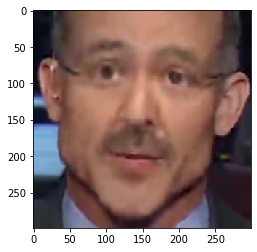

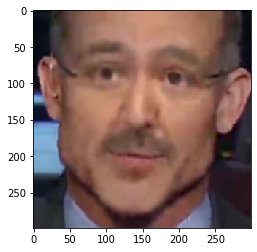

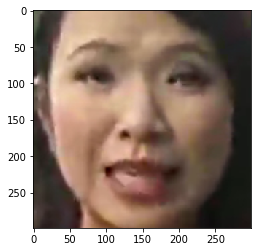

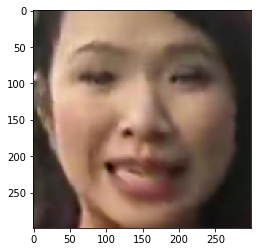

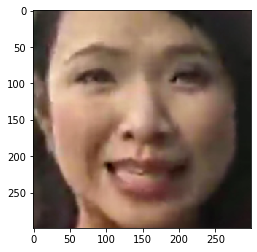

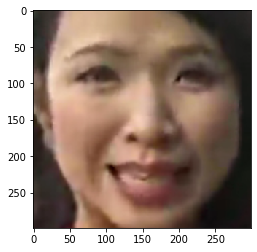

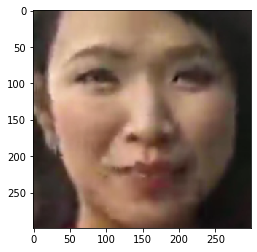

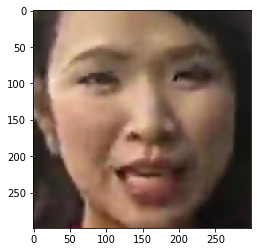

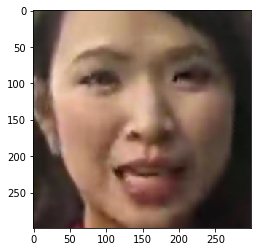

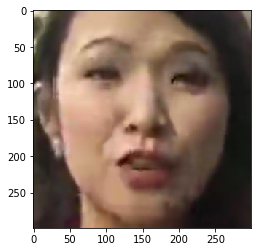

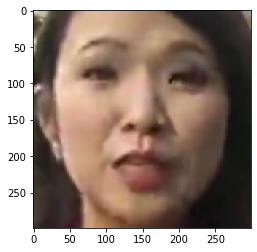

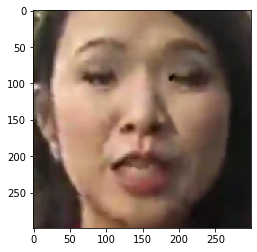

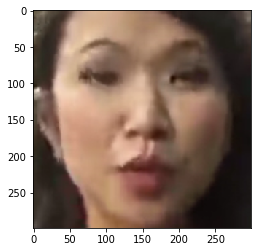

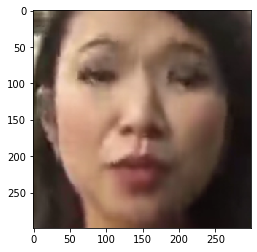

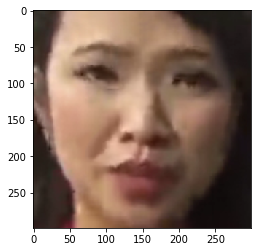

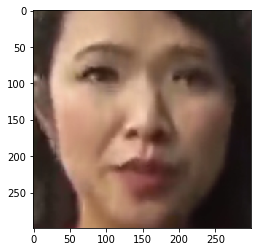

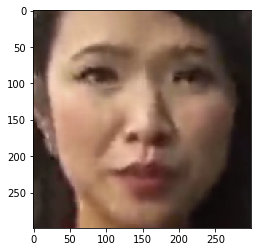

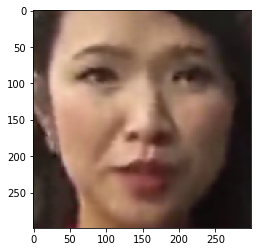

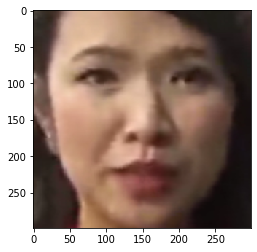

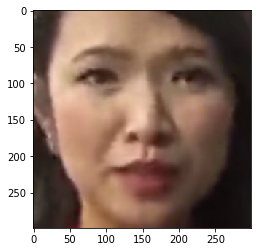

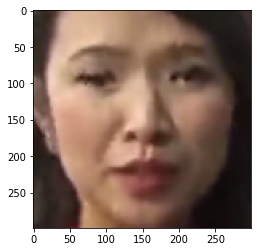

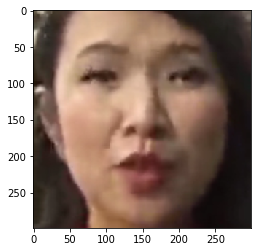

Exception: debug

In [13]:
# Start training

'''
During the first epoch, all required images (and warps) are loaded into RAM, if the option caching was chosen previously.
This might take a while, but after the first epoch, it will be faster.
The loading is done during the first epoch and not when loading the dataloader,
because it would take ~1 hour (in google colab) just to load all data before we can see any 
training output. Instead, we can start right away and load just-in-time.

Note that the first epoch is only slow when a brand-new data_loader is used.
Using the same data_loader for multiple trainings keeps the images loaded.

Warning: Only use this if the RAM is big enough to store all images...
'''
%matplotlib inline
solver.train(model, train_loader, validation_loader, num_epochs=10, log_nth=100)

# Test

Test with same fake set and different fake set as for training.
Will load the data and start the training.

Visualizations can be seen in Tensorboard above.

In [ ]:
# Load test data for all fake types that were trained on according to "locations" variable defined above

#same_test_data_location = ["/content/drive/My Drive/FaceForensics_Sequences/FaceForensics_Testset/original_sequences/youtube/c40/sequences_299x299_5seq@10frames_skip_5_uniform",
#                 "/content/drive/My Drive/FaceForensics_Sequences/FaceForensics_Testset/manipulated_sequences/Deepfakes/c40/sequences_299x299_5seq@10frames_skip_5_uniform"]

#same_test_data_location = ["/content/drive/My Drive/FaceForensics_Sequences/FaceForensics_Testset/original_sequences/youtube/c40/sequences_299x299_10seq@5frames_skip_1_uniform",
#                 "/content/drive/My Drive/FaceForensics_Sequences/FaceForensics_Testset/manipulated_sequences/Deepfakes/c40/sequences_299x299_10seq@5frames_skip_1_uniform"]

if is_large_dataset:
    same_test_data_location = [root_path + s + "/test" for s in locations]
else:
    same_test_data_location = [root_path + "/FaceForensics_Testset" + s for s in locations]
    
same_test_dataset = FaceForensicsVideosDataset(same_test_data_location,
                                               transform=ToTensor(),
                                               num_frames=10, #num_frames=5
                                               #max_number_videos_per_directory=20,
                                               calculateOpticalFlow=opticalFlowEnabled,
                                               verbose=False,
                                               caching=not is_large_dataset)

same_test_indices = range(len(same_test_dataset))

same_test_sampler = SubsetRandomSampler(same_test_indices)

same_test_loader = torch.utils.data.DataLoader(same_test_dataset,
                                               batch_size=dataset_args["batch_size"], 
                                               sampler=same_test_sampler,
                                               num_workers=4)

print("Length of same fake test set: {}".format(len(same_test_dataset)))
print("Loaded test set: {}".format(same_test_data_location))

In [ ]:
# Start testing

solver.test(model, same_test_loader, test_prefix="Same_Fake_Method", log_nth=100)

In [ ]:
# Load test data for one specific (different) fake type

fake_type = "NeuralTextures" # NeuralTextures, FaceSwap, Face2Face, Deepfakes

# because we constructed two different folders, one with 100 videos, one with 1000 videos and the directory structure is different
if is_large_dataset:
    dif_test_data_location = [root_path + "/original_sequences/youtube/c40/" + sequence + "/test",
                              root_path + "/manipulated_sequences/" + fake_type + "/c40/" + sequence + "/test"]
else:
    dif_test_data_location = [root_path + "/FaceForensics_Testset/original_sequences/youtube/c40/" + sequence,
                              root_path + "/FaceForensics_Testset/manipulated_sequences/" + fake_type + "/c40/" + sequence]

dif_test_dataset = FaceForensicsVideosDataset(dif_test_data_location,
                                              transform=ToTensor(),
                                              num_frames=10,
                                              #max_number_videos_per_directory=4,
                                              calculateOpticalFlow=opticalFlowEnabled,
                                              verbose=False,
                                              caching=not is_large_dataset) #num_frames=5

dif_test_indices = range(len(dif_test_dataset))

dif_test_sampler = SubsetRandomSampler(dif_test_indices)

dif_test_loader = torch.utils.data.DataLoader(dif_test_dataset,
                                              batch_size=dataset_args["batch_size"], 
                                              sampler=dif_test_sampler,
                                              num_workers=1)

print("Length of dif fake test set: {}".format(len(dif_test_dataset)))

In [ ]:
# Start testing

solver.test(model, dif_test_loader, test_prefix="Different_Fake_Method_" + fake_type, log_nth=100)

# Save the model

Save network with its weights to disk.

See torch.save function: https://pytorch.org/docs/stable/notes/serialization.html#recommend-saving-models 

Load again with `the_model = TheModelClass(*args, **kwargs) the_model.load_state_dict(torch.load(PATH))`

In [ ]:
def save_model(modelname, model):
    filepath = root_dir + "/adl4cv/saved_results/models/" + modelname + ".pt"
    torch.save(model.state_dict(), filepath)

In [ ]:
save_model("temporal_encoder_2_" + id_suffix, model)

In [ ]:
# LOAD MODEL AGAIN for verification purposes
# Should print: <All keys matched successfully>
#filepath = root_dir + "/adl4cv/saved_results/models/" + "temporal_encoder_2_" + id_suffix + ".pt"
filepath = root_dir + "/adl4cv/saved_results/models/" + "temporal_encoder_2_2020-Jan-22_07-30-13_a59af72e-3ce0-11ea-b9eb-d0509936bc3f.pt"
model.load_state_dict(torch.load(filepath))